# 3조_임재원_물류이동량 예측
- ---
## · 목적
- 제주시 내 택배 운송 데이터를 이용하여 운송량 예측
## · 데이터
- train.csv
    - index : 인덱스
    - 송하인_격자공간고유번호
    - 수하인 격자공간고유번호
    - 택배_카테고리
    - 운송장_건수
- test.csv
    - index : 인덱스
    - 송하인_격자공간고유번호
    - 수하인 격자공간고유번호
    - 택배_카테고리
- 데이터 수집 시점 : 20년 01월

In [57]:
# 모듈 로딩
import pandas as pd
import time
import numpy as np
import platform
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
from sklearn.utils import all_estimators
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import PoissonRegressor
from xgboost import XGBRegressor
from sklearn.model_selection import KFold
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder

# [1] 데이터 로딩 및 확인

In [8]:
# train data 불러오기
data = pd.read_csv(r'./data/train.csv')
print(data.head(5))

# test data 불러오기
test_data = pd.read_csv(r'./data/test.csv')
print(test_data.head(5))

   index      송하인_격자공간고유번호      수하인_격자공간고유번호 물품_카테고리  운송장_건수
0      0  5011000595017300  2871000192069300      음반       3
1      1  4148000690043300  5011000264024400   문화컨텐츠       3
2      2  5011000078068400  1120000007005400     농산물       3
3      3  4127100048006400  5011000587019400    기타식품       7
4      4  5011000078068400  2823700010076300     농산물       3
   index      송하인_격자공간고유번호      수하인_격자공간고유번호      물품_카테고리
0      0  4167000577042200  5011000435014100          선케어
1      1  1156000009012200  5011000172034400       구강위생용품
2      2  4122000363057300  5011000361097300           캠핑
3      3  5011000436041400  2826000084036400       아웃도어가구
4      4  4150000241065200  5011000169044300  분유/이유식/아기간식


In [9]:
# 데이터 종류 확인
print(len(data['물품_카테고리'].unique()))
print(len(test_data['물품_카테고리'].unique()))

# 결측치 확인
print(data.isnull().sum())
print(test_data.isnull().sum())

100
100
index           0
송하인_격자공간고유번호    0
수하인_격자공간고유번호    0
물품_카테고리         0
운송장_건수          0
dtype: int64
index           0
송하인_격자공간고유번호    0
수하인_격자공간고유번호    0
물품_카테고리         0
dtype: int64


# [2] 데이터 전처리
### · 'index'열은 input_data로써의 의미가 없음
- 'index'열 제거
### · 격자공간고유번호 앞 5자리 까지는 시군구 / 동을 뜻함
- 격자공간고유번호 앞 5자리까지만 분리
### · 제주도 관내 / 제주도 -> 타지역 이동은 물류이동이 다른 양상을 보일 것이라 생각함, 따라서 물류 타입을 3가지로 분류
1. 제주도 관내 (0)
2. 관외 -> 제주도 (1)
3. 제주도 -> 관외 (2)
### · 머신 러닝의 예측력을 상승시키기 위해 문자형인 '물품_카테고리'열을 인코딩 시켜줌(label encoding)
- 카테고리의 종류가 너무 많기 때문에 one-hot encoding은 생략, label encoding만 진행하였음
- 문자형 -> 숫자형으로 변환
### · target 스케일링 진행

In [10]:
# 전처리 함수 생성
def data_processing(dataframe):
    # 'index'열 제거
    dataframe.drop(['index'], axis=1, inplace=True)

    # 행정구역 분리
    dataframe['arr'] = 0
    for i in range(len(dataframe['송하인_격자공간고유번호'])):
        dataframe['arr'][i] = dataframe['송하인_격자공간고유번호'][i].astype(str)[:5]
    dataframe['dep'] = 0
    for i in range(len(dataframe['수하인_격자공간고유번호'])):
        dataframe['dep'][i] = dataframe['수하인_격자공간고유번호'][i].astype(str)[:5]
    dataframe.drop(['송하인_격자공간고유번호'], axis=1, inplace=True)
    dataframe.drop(['수하인_격자공간고유번호'], axis=1, inplace=True)

    # 물류타입 생성
    dataframe['type'] = 0
    for i in range(len(dataframe['arr'])):
        if dataframe['arr'][i].astype(str)[:2] == '50' and dataframe['dep'][i].astype(str)[:2] == '50':
            dataframe['type'][i] = 0
        elif dataframe['arr'][i].astype(str)[:2] != '50' and dataframe['dep'][i].astype(str)[:2] == '50':
            dataframe['type'][i] = 1
        elif dataframe['arr'][i].astype(str)[:2] == '50' and dataframe['dep'][i].astype(str)[:2] != '50':
            dataframe['type'][i] = 2

    # 라벨 인코딩
    encoder = LabelEncoder()
    encoder.fit(dataframe['물품_카테고리'])
    labels = encoder.transform(dataframe['물품_카테고리'])
    dataframe['category_labeling'] = labels

In [11]:
data_processing(data)
data_processing(test_data)

C:\ProgramData\Anaconda3\envs\EV_PY37\lib\site-packages\ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':
C:\ProgramData\Anaconda3\envs\EV_PY37\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
C:\ProgramData\Anaconda3\envs\EV_PY37\lib\site-packages\ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Progra

In [12]:
# 전처리된 데이터 확인
print(data.head(5))
print(test_data.head(5))

  물품_카테고리  운송장_건수    arr    dep  type  category_labeling
0      음반       3  50110  28710     2                 67
1   문화컨텐츠       3  41480  50110     1                 34
2     농산물       3  50110  11200     2                 27
3    기타식품       7  41271  50110     1                 17
4     농산물       3  50110  28237     2                 27
       물품_카테고리    arr    dep  type  category_labeling
0          선케어  41670  50110     1                 47
1       구강위생용품  11560  50110     1                 12
2           캠핑  41220  50110     1                 88
3       아웃도어가구  50110  28260     2                 58
4  분유/이유식/아기간식  41500  50110     1                 39


# [3] Type별 물동량 시각화

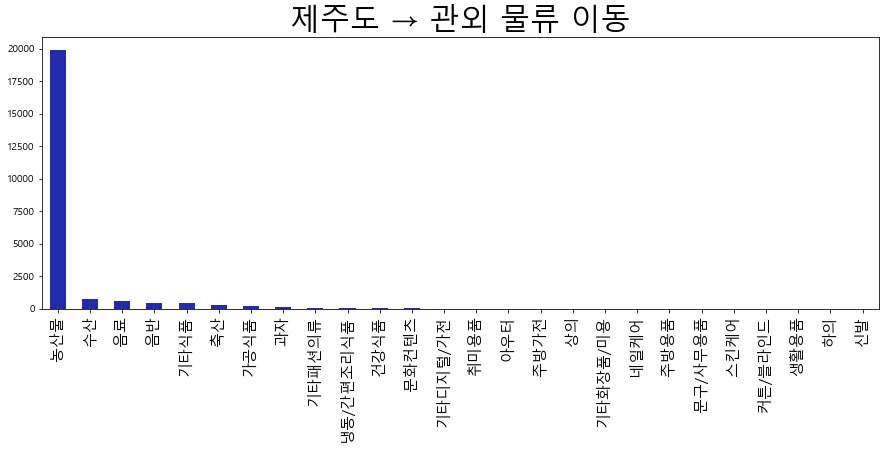

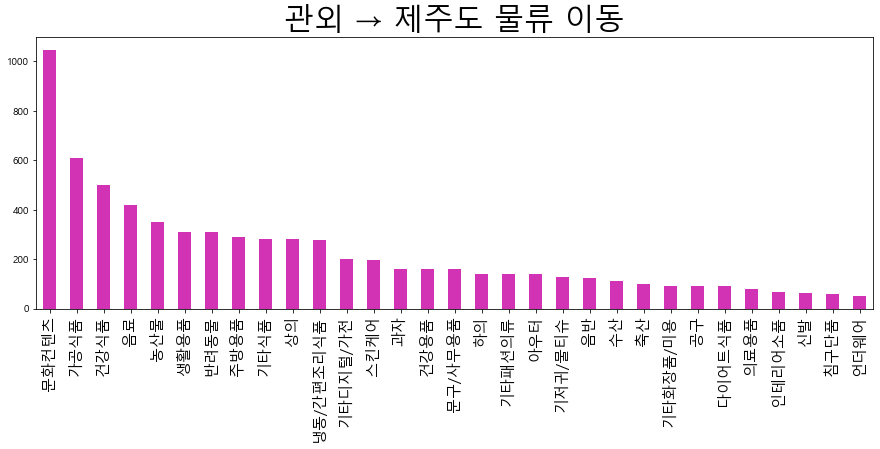

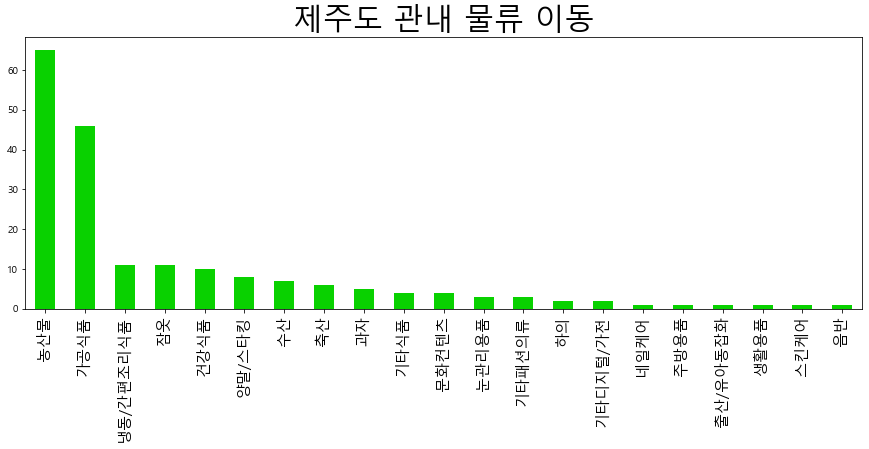

In [13]:
# 폰트타입 지정
if platform.system() == 'Windows':
    font_name = fm.FontProperties(fname='c:\Windows\Fonts\malgun.ttf').get_name()
    plt.rc('font', family=font_name)
else:
    plt.rc('font', family='AppleGothic', size=8)

# 물류 타입별 분리
type_0 = data[data['type'] == 0]
type_1 = data[data['type'] == 1]
type_2 = data[data['type'] == 2]

# type별 물동량 시각화로 확인
plt.figure(figsize=(15, 5))
plt.title('제주도 → 관외 물류 이동', fontsize=30)
type_2['물품_카테고리'].value_counts().loc[lambda x: x > 5].plot(kind='bar', color='#232caf')
plt.xticks(rotation=90, fontsize=15)
plt.show()

plt.figure(figsize=(15, 5))
plt.title('관외 → 제주도 물류 이동', fontsize=30)
type_1['물품_카테고리'].value_counts().loc[lambda x: x > 50].plot(kind='bar', color='#d233b5')
plt.xticks(rotation=90, fontsize=15)
plt.show()

plt.figure(figsize=(15, 5))
plt.title('제주도 관내 물류 이동', fontsize=30)
type_0['물품_카테고리'].value_counts().plot(kind='bar', color='#09d100')
plt.xticks(rotation=90, fontsize=15)
plt.show()

# [4] 모델 생성 준비

In [139]:
# train / test 데이터 분리(시간상 1000개의 샘플만을 분리하였음)
data_sample = data.sample(n=1000, random_state=42)
input_data_sample = data_sample[['arr', 'dep', 'type', 'category_labeling']]
input_target_sample = data_sample['운송장_건수']

input_data = data[['arr', 'dep', 'type', 'category_labeling']]
input_target = data['운송장_건수']

train_x, test_x, train_y, test_y = train_test_split(input_data_sample,
                                                    input_target_sample,
                                                    test_size=0.2,
                                                    random_state=42)

train_realx, test_realx, train_realy, test_realy = train_test_split(input_data,
                                                    input_target,
                                                    test_size=0.2,
                                                    random_state=42)

In [147]:
# 최적의 모델을 찾기위한 score 검색
models = all_estimators(type_filter='regressor')
scores = []
for name, model in models:
    try:
        # 모델 객체 생성
        md = model()
        md.fit(train_realx, train_realy)
        score = md.score(train_realx, train_realy)
        scores.append((name, score))
    except:
        pass
scores

C:\ProgramData\Anaconda3\envs\EV_PY37\lib\site-packages\sklearn\cross_decomposition\_pls.py:252: FutureWarning: As of version 0.24, n_components(2) should be in [1, min(n_features, n_samples, n_targets)] = [1, 1]. n_components=1 will be used instead. In version 1.1 (renaming of 0.26), an error will be raised.
  FutureWarning,
C:\ProgramData\Anaconda3\envs\EV_PY37\lib\site-packages\sklearn\linear_model\_glm\link.py:90: RuntimeWarning: overflow encountered in exp
  return np.exp(lin_pred)
C:\ProgramData\Anaconda3\envs\EV_PY37\lib\site-packages\sklearn\linear_model\_glm\link.py:93: RuntimeWarning: overflow encountered in exp
  return np.exp(lin_pred)
C:\ProgramData\Anaconda3\envs\EV_PY37\lib\site-packages\sklearn\_loss\glm_distribution.py:132: RuntimeWarning: divide by zero encountered in true_divide
  return -2 * (y - y_pred) / self.unit_variance(y_pred)
C:\ProgramData\Anaconda3\envs\EV_PY37\lib\site-packages\sklearn\_loss\glm_distribution.py:132: RuntimeWarning: invalid value encountere

[('ARDRegression', 0.0),
 ('AdaBoostRegressor', 0.14082238422646898),
 ('BaggingRegressor', 0.42603938057377233),
 ('BayesianRidge', 0.004187071441818069),
 ('CCA', -1.1238474318107792),
 ('DecisionTreeRegressor', 0.468916095700598),
 ('DummyRegressor', 0.0),
 ('ElasticNet', 0.004186488137452038),
 ('ElasticNetCV', 0.004186478109113545),
 ('ExtraTreeRegressor', 0.468916095700598),
 ('ExtraTreesRegressor', 0.468916095700598),
 ('GammaRegressor', -4.440892098500626e-16),
 ('GaussianProcessRegressor', 0.4689160953781343),
 ('GradientBoostingRegressor', 0.15379829344823392),
 ('HistGradientBoostingRegressor', 0.22128643264134273),
 ('HuberRegressor', -0.03562209012342188),
 ('KNeighborsRegressor', 0.23057369124622074),
 ('KernelRidge', -0.0024410272038923875),
 ('Lars', 0.004188963194988515),
 ('LarsCV', 0.004119291913666334),
 ('Lasso', 0.004186487898670377),
 ('LassoCV', 0.004186478109503455),
 ('LassoLars', 0.0),
 ('LassoLarsCV', 0.004119291913666334),
 ('LassoLarsIC', 0.004183866443012

In [56]:
# 2개의 모델 선정
model_XGB = XGBRegressor()
model_XGB.fit(train_x, train_y)

model_RFR = RandomForestRegressor()
model_RFR.fit(train_x, train_y)

RandomForestRegressor()

In [58]:
# 최적의 하이퍼 파라미터 찾기(XGBRegressor)
XGB_params = {'max_depth': [2, 4, 6],
              'n_estimators': [100, 500, 1000],
              'colsample_bytree': [0.2, 0.6, 0.8],
              'min_child_weight': [3, 5, 7],
              'gamma': [0.3, 0.5, 0.7],
              'subsample': [0.4, 0.6, 0.8]}

grid = GridSearchCV(estimator=model_XGB,
                    param_grid=XGB_params,
                    n_jobs=-1,
                    cv=5,
                    verbose=1)

start = time.time()
grid.fit(train_x, train_y)
end = time.time()
print(f'소요시간 : {end - start}s')
print("Best parameters:", grid.best_params_)
print('best_estimator_:', grid.best_estimator_)

Fitting 5 folds for each of 729 candidates, totalling 3645 fits


KeyboardInterrupt: 

In [97]:
# 최적의 하이퍼 파라미터 찾기(RandomForestRegressor)
RFR_params = {'max_depth': [None,10,50,100,200],
              'n_estimators': [50, 100, 150, 200],
              'max_samples': [0.2, 0.4],
              'max_features': [0.2, 0.5, 1.0]}

grid = GridSearchCV(estimator=model_RFR,
                    param_grid=RFR_params,
                    n_jobs=-1,
                    cv=5,
                    verbose=1)

start = time.time()
grid.fit(train_x, train_y)
end = time.time()
print(f'소요시간 : {end - start}s')
print("Best parameters:", grid.best_params_)
print('best_estimator_:', grid.best_estimator_)

Fitting 5 folds for each of 120 candidates, totalling 600 fits
소요시간 : 19.235498905181885s
Best parameters: {'max_depth': 10, 'max_features': 0.5, 'max_samples': 0.2, 'n_estimators': 100}
best_estimator_: RandomForestRegressor(max_depth=10, max_features=0.5, max_samples=0.2)


# [5] 최종 모델 생성
- 최적화된 하이퍼 파라미터를 바탕으로 모델 생성
- 하려했으나 하이퍼 파라미터를 넣으면 넣을수록 모델의 성능이 저하되어서 default값으로 진행하기로 함

In [145]:
model_RFR = RandomForestRegressor(random_state=42, n_jobs=-1)
model_RFR.fit(train_realx, train_realy)
model_RFR.score(train_realx, train_realy)
# model_RFR.predict(test_data[['arr', 'dep', 'type', 'category_labeling']])

0.44054119997737573

In [146]:
model_XGB = XGBRegressor(random_state=42, n_jobs=-1)
model_XGB.fit(train_realx, train_realy)
model_XGB.score(train_realx, train_realy)

0.4127363798367989